# Chapter 1 Dataset

문제0. (기본 세팅) torch, torchvision.transforms, pathlib, sklearn, numpy, PIL 라이브러리를 불러오세요

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from pathlib import Path
from sklearn.model_selection import train_test_split
import os
import numpy as np
import random
from PIL import Image

문제1. Reproducibility를 위해 시드를 17로 설정해주세요.

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(17)

문제2. dog, cat 변수를 만들어 dog, cat 폴더에 들어있는 파일의 경로들을 리스트 형태로 저장하세요.

In [3]:
cat = list(Path('./training_set/training_set/cats').iterdir())
dog = list(Path('./training_set/training_set/dogs').iterdir())

문제 3. 저장한 리스트를 각각 8:2의 비율로 나눈 후, train / validation 로 만들어주세요.

In [4]:
cat_train, cat_val = train_test_split(cat,test_size=0.2,random_state=1)
dog_train, dog_val = train_test_split(dog,test_size=0.2,random_state=1)

In [5]:
train = cat_train + dog_train
validation = cat_val + dog_val

# 리스트 순서 랜덤 정렬
np.random.shuffle(train)
np.random.shuffle(validation)

문제 4. torchvision.transforms를 이용하여 이미지 데이터에 변화를 줄 수 있는데, 이를 아래 지시에 맞게
만들어주세요.

문제 4-1. 훈련 데이터셋은 이미지 Resize (크기는 128, 128)-> RandomHorizontalFlip -> tensor로 변환하도록 train_transforms 변수에 저장

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

문제 4-2. 검증 데이터셋은 이미지를 Resize (크기는 128, 128)-> tensor로 변환하도록 val_transforms 
변수에 저장

In [7]:
val_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

문제 5. Dataset class를 만들어주세요. Dataset class는 torch.utils.data.Dataset을 상속받아 만들어야 하
며, 클래스 내부에는 __init__, __len__, __getitem__ 함수가 필수적으로 구현되어 있어야 합니다.


In [8]:
class Data(torch.utils.data.Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        fname = str(self.data[idx])
        f = Image.open(fname)
        
        if self.transforms:
            img = self.transforms(f)
        else:
            img = np.array(f)
            
        if 'cat' in fname:
            lab = 0
        elif 'dog' in fname:
            lab = 1
        else:
            raise("Error")
        
        return img, lab

문제 6. 만든 Dataset class를 이용하여 train, validation 데이터를 Dataset의 형식으로 바꿔주세요.

In [9]:
train_D = Data(train, transforms=train_transforms)
val_D = Data(validation, transforms=val_transforms)

문제 6-1. 만든 dataset에 문제가 없는지 확인하기 위해, dataset의 길이와 첫 번째 data를 출력해보세요

In [10]:
print(len(train_D),len(val_D))

6404 1601


문제 7. 만든 Dataset을 Dataloader로 만들어주세요. 배치 사이즈는 64로, train dataloader는 데이터가
잘 섞이도록 만들어주세요.


In [11]:
train_loader = torch.utils.data.DataLoader(train_D, 64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_D, 64)

# Chapter 2 Modelling
* 이미지 데이터를 다루는 CNN을 만들고 학습시킬 예정
* 직접 구현한 CNN을 사용하는 것과 더불어, 대규모 데이터셋으로 사전 훈련된 모델을 불러와 fine-tuning, transfer learning도 다룰 예정


문제1. CNN 모델을 class의 형태로 만들어주세요. 모델을 만들 때에는 torch.nn.Module을 상속 받아야하며,
init, forward 함수가 필수적으로 구현되어 있어야 합니다.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc = nn.Linear(1024, 2)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

문제2. torch.device() 함수를 이용하여 사용할 장치를 그래픽카드로 설정한 후 모델을 그래픽카드에 할당해주세요.

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net().to(device)

문제3. 사용할 optimizer와 loss function을 정의해주세요. Optimizer는 Adam, learning rate 파라미터는 0.001로 설정해주세요

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

문제4. 2중 for문을 이용해 모델을 학습해주세요. Iteration이 100번 지날 때마다 loss값을 출력하도록 해주세요

In [15]:
EPOCHS = 30

for epoch in range(EPOCHS):
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = criterion(out, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}],␣,→Loss: {loss.item():.4f}')

Epoch [1/30], Step [100/101],␣,→Loss: 0.5975
Epoch [2/30], Step [100/101],␣,→Loss: 0.3507
Epoch [3/30], Step [100/101],␣,→Loss: 0.5716
Epoch [4/30], Step [100/101],␣,→Loss: 0.3141
Epoch [5/30], Step [100/101],␣,→Loss: 0.4015
Epoch [6/30], Step [100/101],␣,→Loss: 0.2125
Epoch [7/30], Step [100/101],␣,→Loss: 0.3576
Epoch [8/30], Step [100/101],␣,→Loss: 0.2646
Epoch [9/30], Step [100/101],␣,→Loss: 0.1799
Epoch [10/30], Step [100/101],␣,→Loss: 0.0833
Epoch [11/30], Step [100/101],␣,→Loss: 0.0746
Epoch [12/30], Step [100/101],␣,→Loss: 0.1122
Epoch [13/30], Step [100/101],␣,→Loss: 0.0714
Epoch [14/30], Step [100/101],␣,→Loss: 0.1886
Epoch [15/30], Step [100/101],␣,→Loss: 0.0685
Epoch [16/30], Step [100/101],␣,→Loss: 0.0375
Epoch [17/30], Step [100/101],␣,→Loss: 0.1030
Epoch [18/30], Step [100/101],␣,→Loss: 0.0600
Epoch [19/30], Step [100/101],␣,→Loss: 0.0485
Epoch [20/30], Step [100/101],␣,→Loss: 0.0766
Epoch [21/30], Step [100/101],␣,→Loss: 0.0223
Epoch [22/30], Step [100/101],␣,→Loss: 0.05

문제5. 모델을 평가 모드로 바꿔주세요.

In [16]:
model.eval()

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

문제6. Train accuracy를 구해보세요.

In [17]:
wrong = torch.tensor([])
with torch.no_grad():
    cnt = 0
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        predicted = torch.argmax(out.data, 1)
        cnt += (label == predicted).sum().item()
        wrong = torch.cat([wrong, data[label != predicted].detach().cpu()])

cnt/len(train_loader)

63.386138613861384

문제7. 같은 방식으로 validation accuracy를 구해보세요. 이때 잘못 예측한 데이터들은 따로 모아주세요.

In [18]:
model.eval()
wrong = torch.tensor([])
with torch.no_grad():
    cnt = 0
    for i, (data, label) in enumerate(val_loader):
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        predicted = torch.argmax(out.data, 1)
        cnt += (label == predicted).sum().item()
        wrong = torch.cat([wrong, data[label != predicted].detach().cpu()])

In [19]:
cnt/len(val_loader)

55.53846153846154

문제8. 위에서 모은 잘못 예측한 데이터 중 하나가 어떻게 생겼는지 살펴주세요

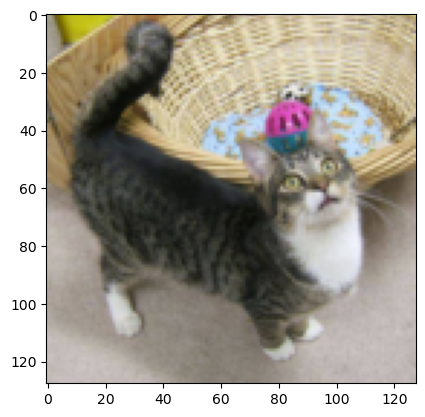

In [20]:
import matplotlib.pyplot as plt
tmp = wrong[-113, :, :, :]
tmp = np.transpose(tmp, (1,2,0))
plt.imshow(tmp)

문제9. Torchvision의 models에서 사전 훈련된 (pretrained) resnet34를 불러와주세요.

In [21]:
from torchvision import models

In [22]:
resnet = models.resnet34(pretrained=True)

문제10. 불러온 모델의 fc layer를 우리가 해결할 문제에 맞게 바꿔주세요.

In [23]:
num_classes = 2  #이진분류를 위한 클래스 개수 설정
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)

In [24]:
resnet = resnet.to(device)

문제11. Fine-tuning과 transfer learning의 차이가 무엇인지 써주세요.

* Fine-tuning (파인 튜닝)은 출력층 및 출력층에 가까운 부분뿐만 아니라 모든 층의 파라미터를 다시 학습한다. 이는 출력층 등을 변경한 모델을 학습된 모델을 기반으로 구축한 후, 직접 준비한 데이터로 신경망 모델의 결합 파라미터 학습하고, 결합 파라미터의 초깃값은 학습된 모델의 파라미터 사용하여 전이학습과 달리, (출력층 및 출력층에 가까운 부분 뿐 아니라) 모든 층의 파라미터 재학습한다. 
* Transfer learning (전이학습)은 입력층에 가까운 부분의 결합 파라미터는 학습된 값으로 변환기키지 않는 특징을 가지고 있다. 학습된 모델의 최종 출력층을 보유 중인 데이터에 대응하는 출력층으로 바꾸고, 교체한 출력층의 결합 파라미터(그릭고 앞 층의 결합 파라미터)를 소량의 데이터로 다시 학습하여 입력층에 가까운 부분의 결합 파라미터를 변화시키지 않는다. 
* *출처: https://velog.io/@hyangki0119/%EB%94%A5%EB%9F%AC%EB%8B%9D-%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5Transfer-learning%EA%B3%BC-%ED%8C%8C%EC%9D%B8-%ED%8A%9C%EB%8B%9DFine-tuning%EC%9D%98-%EC%B0%A8%EC%9D%B4%EC%A0%90*

문제12. 불러온 모델을 train data로 학습시켜주세요. 이때 사용하는 optimizer와 loss function은 위와 동일하며, epoch는 10회로 해주세요

In [25]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
EPOCHS = 10

for epoch in range(EPOCHS):
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        out = resnet(data)
        loss = criterion(out, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}],␣,→Loss: {loss.item():.4f}')

Epoch [1/10], Step [100/101],␣,→Loss: 0.1050
Epoch [2/10], Step [100/101],␣,→Loss: 0.1379
Epoch [3/10], Step [100/101],␣,→Loss: 0.0719
Epoch [4/10], Step [100/101],␣,→Loss: 0.1475
Epoch [5/10], Step [100/101],␣,→Loss: 0.1427
Epoch [6/10], Step [100/101],␣,→Loss: 0.2325
Epoch [7/10], Step [100/101],␣,→Loss: 0.0886
Epoch [8/10], Step [100/101],␣,→Loss: 0.1253
Epoch [9/10], Step [100/101],␣,→Loss: 0.0872
Epoch [10/10], Step [100/101],␣,→Loss: 0.0696


문제13. 모델을 평가 모드로 바꾼 후, 학습한 모델의 train accuracy, validation accuracy를 구해주세요.

In [26]:
resnet.eval()
wrong = torch.tensor([])
with torch.no_grad():
    cnt = 0
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        out = resnet(data)
        _, predicted = torch.max(out.data, 1)
        cnt += (label == predicted).sum().item()
        wrong = torch.cat([wrong, data[label != predicted].detach().cpu()])
        
cnt/len(train_loader)

61.16831683168317

In [28]:
resnet.eval()
wrong = torch.tensor([])
with torch.no_grad():
    cnt = 0
    for i, (data, label) in enumerate(val_loader):
        data = data.to(device)
        label = label.to(device)
        out = resnet(data)
        predicted = torch.argmax(out.data, 1)
        cnt += (label == predicted).sum().item()
        wrong = torch.cat([wrong, data[label != predicted].detach().cpu()])
        
cnt/len(val_loader)

56.73076923076923

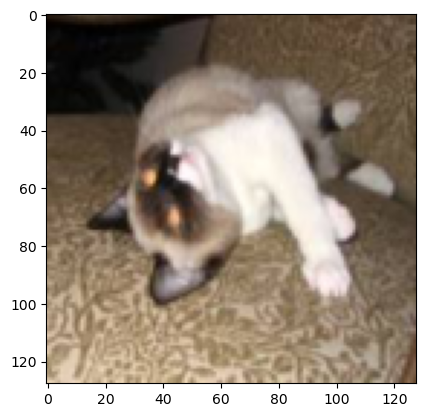

In [29]:
import matplotlib.pyplot as plt
tmp = wrong[-33, :, :, :]
tmp = np.transpose(tmp, (1,2,0))
plt.imshow(tmp)

문제14. Pretrained resnet34를 다시 불러와 fc layer를 우리가 해결할 문제에 맞게 바꿔주세요.

In [30]:
resnet = models.resnet34(pretrained=True)

num_classes = 2
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)

In [31]:
for param in resnet.parameters():
    param.requires_grad = False
    
resnet.fc.weight.requires_grad = True
resnet.fc.bias.requires_grad = True

In [32]:
resnet = resnet.to(device)

문제15. 불러온 모델을 train data로 학습시켜주세요. 이때 학습을 통해 fc layer만 업데이트하도록 설정해주시고, 사용하는 optimizer와 loss function은 위와 동일하며, epoch는 10회로 해주세요.

In [33]:
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
EPOCHS = 10

for epoch in range(EPOCHS):
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        out = resnet(data)
        loss = criterion(out, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}],␣,→Loss: {loss.item():.4f}')


Epoch [1/10], Step [100/101],␣,→Loss: 0.2049
Epoch [2/10], Step [100/101],␣,→Loss: 0.2040
Epoch [3/10], Step [100/101],␣,→Loss: 0.1715
Epoch [4/10], Step [100/101],␣,→Loss: 0.1452
Epoch [5/10], Step [100/101],␣,→Loss: 0.1389
Epoch [6/10], Step [100/101],␣,→Loss: 0.1300
Epoch [7/10], Step [100/101],␣,→Loss: 0.1346
Epoch [8/10], Step [100/101],␣,→Loss: 0.2720
Epoch [9/10], Step [100/101],␣,→Loss: 0.1796
Epoch [10/10], Step [100/101],␣,→Loss: 0.0658


문제16. 모델을 평가 모드로 바꾼 후, 학습한 모델의 train accuracy, validation accuracy를 구해주세요

In [34]:
resnet.eval()
wrong = torch.tensor([])
with torch.no_grad():
    cnt = 0
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        out = resnet(data)
        predicted = torch.argmax(out.data, 1)
        cnt += (label == predicted).sum().item()
        wrong = torch.cat([wrong, data[label != predicted].detach().cpu()])
        
cnt/len(train_loader)

59.366336633663366

In [35]:
resnet.eval()
wrong = torch.tensor([])
with torch.no_grad():
    cnt = 0
    for i, (data, label) in enumerate(val_loader):
        data = data.to(device)
        label = label.to(device)
        out = resnet(data)
        predicted = torch.argmax(out.data, 1)
        cnt += (label == predicted).sum().item()
        wrong = torch.cat([wrong, data[label != predicted].detach().cpu()])
        
cnt/len(val_loader)

57.07692307692308

In [36]:
cnt

1484